In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pycocotools.coco as coco
from pycocotools.cocoeval import COCOeval
import numpy as np
import json, os, torch, math, sys, cv2
import torch.utils.data as data
import vsrl_utils as vu

sys.path.append("/home/shuchen/data/github/tmp/IP-Net/src/lib/")

from random import choice
from pathlib import Path
from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
class VCOCO(data.Dataset):
    
    def __init__(self, opt, split):
        super().__init__()
        
        self.img_dir = Path('/home/shuchen/data/github/iCAN/Data/v-coco/coco/images/train2014')
        base_ann_path = Path('/home/shuchen/data/github/iCAN/Data/v-coco/data')
        
        # Load COCO annotations for V-COCO images
        self.coco = vu.load_coco(base_ann_path)

        # Load the VCOCO annotations for vcoco image set
        print(f'==> initializing vcoco 2014 {split} data.')
        
        if split == 'train':
            self.vcoco_split = vu.load_vcoco('vcoco_train', base_ann_path)
        elif split == 'val':
            self.vcoco_split = vu.load_vcoco('vcoco_val', base_ann_path)
        elif split == 'test':
            self.vcoco_split = vu.load_vcoco('vcoco_test', base_ann_path)
        else:
            raise NotImplementedError

        self.action_names = ['hold', 'stand', 'sit', 'ride', 'walk', 'look', 'hit', 'eat', 'jump', 'lay', 'talk_on_phone', 
         'carry', 'throw', 'catch', 'cut', 'run', 'work_on_computer', 'ski', 'surf', 'skateboard', 
         'smile', 'drink', 'kick', 'point', 'read', 'snowboard']
        
        self.num_act_classes = 26
        self.num_obj_classes = 80
        self.class_name = [
              '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
              'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
              'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
              'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
              'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
              'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
              'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
              'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
              'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']
        self._valid_ids = [
              1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,
              14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
              24, 25, 27, 28, 31, 32, 33, 34, 35, 36,
              37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
              48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
              58, 59, 60, 61, 62, 63, 64, 65, 67, 70,
              72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
              82, 84, 85, 86, 87, 88, 89, 90]
        self.cat_ids = {v: i for i, v in enumerate(self._valid_ids)}

        self.voc_color = [(v // 32 * 64 + 64, (v // 8) % 4 * 64, v % 8 * 32) for v in range(1, self.num_obj_classes + 1)]
        self._data_rng = np.random.RandomState(123)
        self._eig_val = np.array([0.2141788, 0.01817699, 0.00341571], dtype=np.float32)
        self._eig_vec = np.array([
            [-0.58752847, -0.69563484, 0.41340352],
            [-0.5832747, 0.00994535, -0.81221408],
            [-0.56089297, 0.71832671, 0.41158938]
        ], dtype=np.float32)
        
        self.default_resolution = [512, 512]
        self.mean = np.array([0.40789654, 0.44719302, 0.47026115], dtype=np.float32).reshape(1, 1, 3)
        self.std  = np.array([0.28863828, 0.27408164, 0.27809835], dtype=np.float32).reshape(1, 1, 3)

        
        self.max_objs = 128
        self.split = split
        self.opt = opt
        self.images = self.vcoco_split[0]['image_id']
        self.num_samples = len(self.images)

        print('Loaded {} {} samples'.format(split, self.num_samples))

    def __len__(self):
        return self.num_samples

    def _coco_box_to_bbox(self, box):
        bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]], dtype=np.float32)
        return bbox

    def _get_border(self, border, size):
        i = 1
        while size - border // i <= border // i:
            i *= 2
        return border // i
        
    def __getitem__(self, index):
        
        # get image id and corresponding actions
        image_id = int(self.vcoco_split[0]['image_id'][index][0])
        image_actions = [x['action_name'] for x in self.vcoco_split if x['label'][index] == [1]]
        image_action_idx = [self.action_names.index(x) for x in image_actions]
        print(f'image_id: {image_id}, image_actions: {image_actions}')

        # get image annotations and actions
        ann_ids = self.coco.getAnnIds(image_id)
        role_object_ids_all = [self.vcoco_split[i]['role_object_id'][index] for i in image_action_idx]
        num_objs = min(len(ann_ids), self.max_objs)
        print(f'ann_ids: {ann_ids}')
        
        # remove 0s from antion annotations
        for i, role_object_ids in enumerate(role_object_ids_all):
            role_object_ids = role_object_ids.flatten().tolist()
            while role_object_ids[-1] == 0:
                role_object_ids.pop()
            role_object_ids_all[i] = role_object_ids
        print(f'role_object_ids_all: {role_object_ids_all}')

        #print(self.coco.loadImgs(image_id))
        file_name = self.coco.loadImgs(image_id)[0]['file_name']
        print(f'file_name: {file_name}')

        img_path = os.path.join(self.img_dir, file_name)
        img = np.array(Image.open(img_path))
        height, width = img.shape[0], img.shape[1]
        c = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)

        self.opt.pad = 127
        self.opt.down_ratio = 4
        self.opt.mse_loss = False
        self.opt.dense_wh = False
        self.opt.cat_spec_wh = False
        self.opt.reg_offset = False
        self.opt.debug = 0
        self.opt.not_rand_crop = False
        self.opt.flip = 0.5
        self.opt.no_color_aug = False
        if True: #self.opt.keep_res:
            input_h = (height | self.opt.pad) + 1
            input_w = (width | self.opt.pad) + 1
            s = np.array([input_w, input_h], dtype=np.float32)
        else:
            s = max(img.shape[0], img.shape[1]) * 1.0
            input_h, input_w = self.opt.input_h, self.opt.input_w

        flipped = False
        if self.split == 'train':
            if not self.opt.not_rand_crop:
                s = s * np.random.choice(np.arange(0.6, 1.4, 0.1))
                w_border = self._get_border(128, img.shape[1])
                h_border = self._get_border(128, img.shape[0])
                c[0] = np.random.randint(low=w_border, high=img.shape[1] - w_border)
                c[1] = np.random.randint(low=h_border, high=img.shape[0] - h_border)
            else:
                sf = self.opt.scale
                cf = self.opt.shift
                c[0] += s * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
                c[1] += s * np.clip(np.random.randn()*cf, -2*cf, 2*cf)
                s = s * np.clip(np.random.randn()*sf + 1, 1 - sf, 1 + sf)

            if np.random.random() < self.opt.flip:
                flipped = True
                # print(img.shape)
                img = img[:, ::-1, :]
                c[0] = width - c[0] - 1

        trans_input = get_affine_transform(c, s, 0, [input_w, input_h])
        inp = cv2.warpAffine(img, trans_input, (input_w, input_h), flags=cv2.INTER_LINEAR)
        inp = (inp.astype(np.float32) / 255.)
        if self.split == 'train' and not self.opt.no_color_aug:
            color_aug(self._data_rng, inp, self._eig_val, self._eig_vec)
        inp = (inp - self.mean) / self.std
        inp = inp.transpose(2, 0, 1)

        output_h = input_h // self.opt.down_ratio
        output_w = input_w // self.opt.down_ratio
        num_obj_classes = self.num_obj_classes
        num_act_classes = self.num_act_classes
        trans_output = get_affine_transform(c, s, 0, [output_w, output_h])

        hm = np.zeros((num_obj_classes, output_h, output_w), dtype=np.float32)
        hm_act = np.zeros((num_act_classes, output_h, output_w), dtype=np.float32)
        wh = np.zeros((self.max_objs, 2), dtype=np.float32)
        wh_act = np.zeros((self.max_objs, 2), dtype=np.float32)
        dense_wh = np.zeros((2, output_h, output_w), dtype=np.float32)
        reg = np.zeros((self.max_objs, 2), dtype=np.float32)
        ind = np.zeros((self.max_objs), dtype=np.int64)
        ind_act = np.zeros((self.max_objs), dtype=np.int64)
        reg_mask = np.zeros((self.max_objs), dtype=np.uint8)
        reg_act_mask = np.zeros((self.max_objs), dtype=np.uint8)
        cat_spec_wh = np.zeros((self.max_objs, num_obj_classes * 2), dtype=np.float32)
        cat_spec_mask = np.zeros((self.max_objs, num_obj_classes * 2), dtype=np.uint8)

        draw_gaussian = draw_msra_gaussian if self.opt.mse_loss else draw_umich_gaussian

        gt_det = []

        p = 0

        # label all action points
        for k in range(num_objs):
            ann_id = ann_ids[k]
            #print('ann_id: ', ann_id)
            ann = self.coco.loadAnns(ann_id)[0]
            bbox = self._coco_box_to_bbox(ann['bbox'])
            cls_id = int(self.cat_ids[ann['category_id']])

            if flipped:
                bbox[[0, 2]] = width - bbox[[2, 0]] - 1
            bbox[:2] = affine_transform(bbox[:2], trans_output)
            bbox[2:] = affine_transform(bbox[2:], trans_output)
            bbox[[0, 2]] = np.clip(bbox[[0, 2]], 0, output_w - 1)
            bbox[[1, 3]] = np.clip(bbox[[1, 3]], 0, output_h - 1)

            h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
            if h > 0 and w > 0:
                radius = gaussian_radius((math.ceil(h), math.ceil(w)))
                radius = max(0, int(radius))
                radius = self.opt.hm_gauss if self.opt.mse_loss else radius
                ct = np.array([(bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2], dtype=np.float32)
                ct_int = ct.astype(np.int32)
                draw_gaussian(hm[cls_id], ct_int, radius)
                wh[k] = 1. * w, 1. * h
                ind[k] = ct_int[1] * output_w + ct_int[0]
                reg[k] = ct - ct_int
                reg_mask[k] = 1
                cat_spec_wh[k, cls_id * 2: cls_id * 2 + 2] = wh[k]
                cat_spec_mask[k, cls_id * 2: cls_id * 2 + 2] = 1
                if self.opt.dense_wh:
                    draw_dense_reg(dense_wh, hm.max(axis=0), ct_int, wh[k], radius)
                gt_det.append([ct[0] - w / 2, ct[1] - h / 2, ct[0] + w / 2, ct[1] + h / 2, 1, cls_id])

                # label all actions related to this person
                if ann['category_id'] == 1:

                    for action_cls, role_object_ids in zip(image_action_idx, role_object_ids_all):
                        if role_object_ids[0] != ann_id:
                            continue

                        print(f'    Action labelling: {ann_id}, {role_object_ids}')
                        
                        if len(role_object_ids) == 1:
                            # actions contain only agent, thus action point is set to the center point of agent
                            draw_gaussian(hm_act[action_cls], ct_int, radius)

                        elif len(role_object_ids) in [2, 3]:
                            # actions contain both agent and object, or
                            # actions contain agent, medium and object, e.g. action cut with (person, knife, apple)
                            # in both cases, first and last ids are used for action point calculation
                            o_ann = self.coco.loadAnns(role_object_ids[-1])[0]
                            o_bbox = self._coco_box_to_bbox(o_ann['bbox'])
                            o_bbox = np.array(o_bbox)
                            if flipped:
                                o_bbox[[0, 2]] = width - o_bbox[[2, 0]] - 1
                            o_bbox[:2] = affine_transform(o_bbox[:2], trans_output)
                            o_bbox[2:] = affine_transform(o_bbox[2:], trans_output)
                            o_bbox[[0, 2]] = np.clip(o_bbox[[0, 2]], 0, output_w - 1)
                            o_bbox[[1, 3]] = np.clip(o_bbox[[1, 3]], 0, output_h - 1)

                            o_h, o_w = o_bbox[3] - o_bbox[1], o_bbox[2] - o_bbox[0]

                            if o_h > 0 and o_w > 0:
                                radius = 10
                                radius = self.opt.hm_gauss if self.opt.mse_loss else radius

                                o_ct = np.array(
                                    [(o_bbox[0] + o_bbox[2]) / 2, (o_bbox[1] + o_bbox[3]) / 2], dtype=np.float32)
                                act_ct = (ct + o_ct) / 2
                                act_ct_int = act_ct.astype(np.int32)

                                h_act, w_act = abs(ct[1] - o_ct[1]), abs(ct[0] - o_ct[0])
                                wh_act[p] = 1. * w_act, 1. * h_act
                                ind_act[p] = act_ct_int[1] * output_w + act_ct_int[0]
                                reg_act_mask[p] = 1

                                p += 1
                                draw_gaussian(hm_act[action_cls], act_ct_int, radius)

                        else:
                            raise NotImplementedError

        ret = {'input': inp, 'hm_act': hm_act, 'wh_act':wh_act, 'ind_act':ind_act, 'reg_act_mask':reg_act_mask}

        if self.opt.dense_wh:
            hm_a = hm.max(axis=0, keepdims=True)
            dense_wh_mask = np.concatenate([hm_a, hm_a], axis=0)
            ret.update({'dense_wh': dense_wh, 'dense_wh_mask': dense_wh_mask})
            del ret['wh']
        elif self.opt.cat_spec_wh:
            ret.update({'cat_spec_wh': cat_spec_wh, 'cat_spec_mask': cat_spec_mask})
            del ret['wh']
        if self.opt.reg_offset:
            ret.update({'reg': reg})
        if self.opt.debug > 0 or not self.split == 'train':
            gt_det = np.array(gt_det, dtype=np.float32) if len(gt_det) > 0 else \
                              np.zeros((1, 6), dtype=np.float32)
            meta = {'c': c, 's': s, 'gt_det': gt_det, 'img_id': image_id}
            ret['meta'] = meta
        return ret


In [52]:
from opts import opts

#vcoco = VCOCO(opts(), 'test')
#vcoco = VCOCO(opts(), 'train')
vcoco = VCOCO(opts(), 'val')

==> initializing vcoco 2014 val data.
Loaded val 4499 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_id: 17914, image_actions: ['hold', 'sit', 'work_on_computer']
ann_ids: [51931, 198716, 1099683, 1957389]
role_object_ids_all: [[198716, 51931], [198716], [198716, 1099683]]
file_name: COCO_train2014_000000017914.jpg
    Action labelling: 198716, [198716, 51931]
    Action labelling: 198716, [198716]
    Action labelling: 198716, [198716, 1099683]


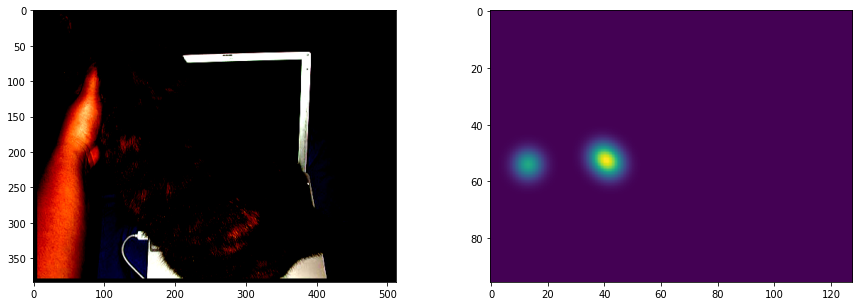

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_id: 524924, image_actions: ['hold', 'stand', 'look', 'cut']
ann_ids: [118312, 198893, 697405, 714896, 1042162, 1047624, 1049537, 1052095, 1052459, 1077431, 1516629, 1524848, 1557165, 1635743, 1934499, 2101695]
role_object_ids_all: [[198893, 697405], [198893], [198893, 1077431], [198893, 697405, 1077431]]
file_name: COCO_train2014_000000524924.jpg
    Action labelling: 198893, [198893, 697405]
    Action labelling: 198893, [198893]
    Action labelling: 198893, [198893, 1077431]
    Action labelling: 198893, [198893, 697405, 1077431]


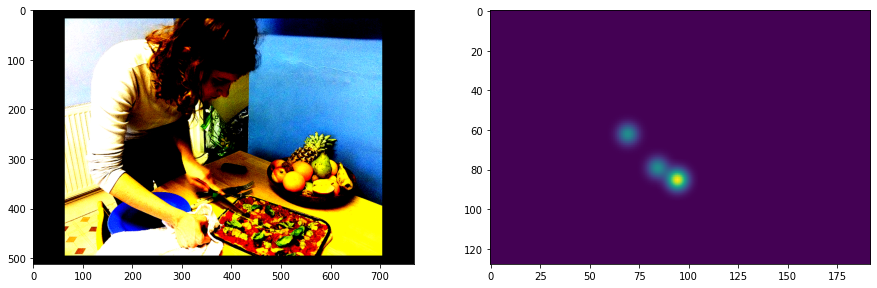

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_id: 355697, image_actions: ['hold', 'sit']
ann_ids: [79174, 99800, 198995, 1495988, 1507351, 1511470, 1513509, 1630515, 1632016, 2136098, 2148875, 2150575]
role_object_ids_all: [[198995, 1630515], [198995, 99800]]
file_name: COCO_train2014_000000355697.jpg
    Action labelling: 198995, [198995, 1630515]
    Action labelling: 198995, [198995, 99800]


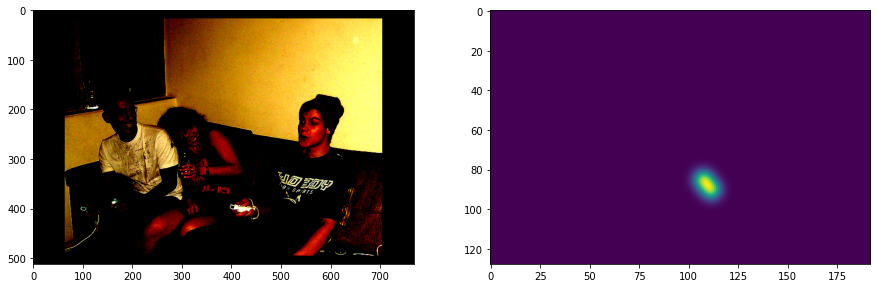

In [54]:
for i in range(200, 203):
    #label = next(iter(vcoco_test))
    label = vcoco[i]
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(label['input'].transpose(1,2,0))

    plt.subplot(122)
    plt.imshow(np.sum(label['hm_act'], axis=0))
    plt.show()
